# MIT dataset

In [1]:
# import some common libraries
import numpy as np
import torch
import torch.nn as nn
import os

import matplotlib.pyplot as plt
from train import train_with_config, train
from evaluator import *
from model import CompoResnet
from symnet.utils import dataset
import tqdm
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 
  
%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/mitstates/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


53753 activations loaded
#images = 34562


In [19]:
from transformers import BertTokenizer, BertForMaskedLM

In [32]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
bert_model = BertForMaskedLM.from_pretrained('bert-large-uncased-whole-word-masking')
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def compo_prob(attr, obj, tokenizer, model):
  attr_promp = tokenizer(f"this {obj} is [MASK].", return_tensors='pt')
  attr_mask_loc = list(attr_promp['input_ids'][0]).index(tokenizer.mask_token_id)
  obj_promp = tokenizer(f"this [MASK] is {attr}.", return_tensors='pt')
  obj_mask_loc = list(obj_promp['input_ids'][0]).index(tokenizer.mask_token_id)
  with torch.no_grad():
    attr_pred = torch.softmax(model(**attr_promp).logits[0][attr_mask_loc].detach(), dim=-1)
    obj_pred = torch.softmax(model(**obj_promp).logits[0][obj_mask_loc].detach(), dim=-1)
  attr_idx, obj_idx = tokenizer.encode([attr, obj])[1:-1]
  attr_prob = attr_pred[attr_idx]
  obj_prob = obj_pred[obj_idx]
  return attr_prob, obj_prob

In [28]:
pairs = [("red", "apple"), ("sweet", "apple"), ("big", "apple"), ("rusty", "apple"), ("ancient", "apple")]
for attr, obj in pairs:
  print(compo_prob(attr, obj, bert_tokenizer, bert_model))

(tensor(0.0151), tensor(0.0003))
(tensor(0.0234), tensor(0.0012))
(tensor(0.0022), tensor(0.0001))
(tensor(6.6761e-05), tensor(0.0004))
(tensor(0.0168), tensor(2.7213e-05))


In [33]:
attr_scores = torch.ones_like(self.seen_mask, dtype=torch.float)
for i in tqdm.tqdm(range(self.attr_class * self.obj_class), total=self.attr_class*self.obj_class):
  attr_id = i // self.obj_class
  obj_id = i % self.obj_class
  if self.unseen_mask_ow[attr_id, obj_id]:
    attr, obj = self.attrs[attr_id], self.objs[obj_id]
    attr_score, obj_score = compo_prob(attr, obj, bert_tokenizer, bert_model)
    attr_scores[attr_id, obj_id] = min(attr_score, obj_score)

100%|██████████| 28175/28175 [2:27:15<00:00,  3.19it/s]  


In [34]:
torch.save(attr_scores, './attr_scores_2.pt')

In [29]:
torch.mean(attr_scores[self.close_mask])

tensor(0.0028, device='cuda:0')

In [30]:
torch.mean(attr_scores[self.unseen_mask_ow])

tensor(0.0007, device='cuda:0')

In [ ]:
seen_attr_scores, _ = torch.sort(attr_scores[self.seen_mask].flatten().cpu())
plt.scatter(range(len(seen_attr_scores)), seen_attr_scores)

In [ ]:
unseen_attr_scores, _ = torch.sort(attr_scores[self.unseen_mask_ow].flatten().cpu())
plt.scatter(range(len(unseen_attr_scores)), unseen_attr_scores)

In [8]:
fscore = torch.load('./fscore.pt')

In [13]:
self = evaluator

In [17]:
torch.mean(fscore[self.unseen_mask_cw]), torch.mean(fscore[self.unseen_mask_ow])

(tensor(0.4026, device='cuda:0'), tensor(0.2632, device='cuda:0'))

In [ ]:
unseen_attr_scores, _ = torch.sort(fscore[self.unseen_mask_ow].flatten().cpu())
plt.scatter(range(len(unseen_attr_scores)), unseen_attr_scores)

In [10]:
# train [img, attr_id, obj_id, pair_id, img_feature, img, attr_id, obj_id, pair_id, img_feature, aff_mask]
# test [img, attr_id, obj_id, pair_id, img_feature, aff_mask]

train_dataloader = dataset.get_dataloader('MITg', 'train', batchsize=64, with_image=True, shuffle=True)
test_dataloader = dataset.get_dataloader('MITg', 'test', batchsize=64, with_image=True)

# train_dataloader = dataset.get_dataloader('UTg', 'train', batchsize=64, with_image=True, shuffle=True)
# test_dataloader = dataset.get_dataloader('UTg', 'test', batchsize=64, with_image=True)

53753 activations loaded
natural split train
#images = 30338
53753 activations loaded
natural split test
#images = 12995


In [8]:
num_mlp_layers = 1
resnet_name = 'resnet18'
compoResnet = CompoResnet(resnet_name, num_mlp_layers).to(dev)

obj_loss_history = [[],[]]
attr_loss_history = [[],[]]
optimizer = torch.optim.AdamW(compoResnet.parameters(), lr=0.0015)
criterion = nn.CrossEntropyLoss()
curr_epoch = 0

model_dir = './models/'
load_model_name = 'model_14.pt'
model_path = None if not load_model_name else os.path.join(model_dir, load_model_name)

if model_path:
  #checkpoint = torch.load(model_path), map_location=torch.device('cpu'))
  checkpoint = torch.load(model_path)
  compoResnet.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  obj_loss_history = checkpoint['obj_loss']
  attr_loss_history = checkpoint['attr_loss']

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
num_epochs = 10
batch_size = 64
curr_epoch = 0
model_name = 'model_ut'
train(compoResnet, optimizer, criterion, num_epochs, obj_loss_history, attr_loss_history, batch_size, train_dataloader, 
      test_dataloader=test_dataloader, curr_epoch=curr_epoch, model_name=model_name, model_dir=model_dir)

In [ ]:
evaluator = CompoResnetEvaluator(test_dataloader, 20)

In [6]:
obj_acc, attr_acc, report_cw, report_ow = evaluator.eval_model(compoResnet)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:31<00:00,  6.38it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.060|OpHM:0.062|OpAUC:0.00706|


**Hard masking**

In [ ]:
results = []
for t in tqdm.tqdm(np.linspace(0.1, 0.5, 20), total=20):
  self.fscore_mask = fscore < t
  results.append(eval_model(self, compoResnet))

In [15]:
auc = [result[-1][-1] for result in results]

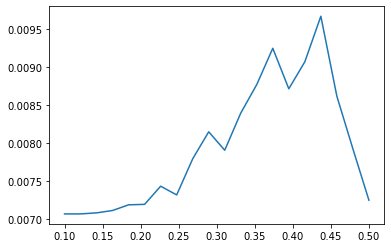

In [16]:
plt.plot(np.linspace(0.1, 0.5, 20), auc)

In [ ]:
evaluator = CompoResnetEvaluatorFscore(test_dataloader, 20, 0.27, './GoogleNews-vectors-negative300.bin')

In [18]:
obj_acc, attr_acc, report_cw, report_ow = results[np.argmax(auc)]

In [37]:
evaluator.fscore = torch.load('./fscore.pt')

In [38]:
obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet, 0.435)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:27<00:00,  7.41it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.080|OpHM:0.073|OpAUC:0.00992|


**Hard masking 2**

In [24]:
word2vec = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

[2021-06-01 16:14:34,816] gensim.models.keyedvectors: loading projection weights from ./GoogleNews-vectors-negative300.bin
[2021-06-01 16:15:00,896] gensim.utils: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from ./GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-06-01T16:15:00.896917', 'gensim': '4.0.1', 'python': '3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) \n[GCC 9.3.0]', 'platform': 'Linux-5.4.0-1048-aws-x86_64-with-debian-buster-sid', 'event': 'load_word2vec_format'}


In [25]:
dset = test_dataloader.dataset
attrs = dset.attrs
objs = dset.objs
w2v_scores = np.zeros((len(attrs), len(objs)))
for attr_id in range(len(attrs)):
  for obj_id in range(len(objs)):
    attr, obj = dset.attrs[attr_id], dset.objs[obj_id]
    attr, obj = word2vec[attr], word2vec[obj]
    w2v_scores[attr_id, obj_id] = np.dot(attr, obj)

In [9]:
evaluator = CompoResnetEvaluatorFscore(test_dataloader, 20, 1e-5, './GoogleNews-vectors-negative300.bin')

In [27]:
evaluator.fscore = w2v_scores

In [35]:
results = []
for t in tqdm.tqdm(np.linspace(0.4, 0.5, 10), total=20):
  results.append(evaluator.eval_model(compoResnet, t))
auc = [result[-1][-1] for result in results]

 50%|█████     | 10/20 [04:44<04:44, 28.46s/it]


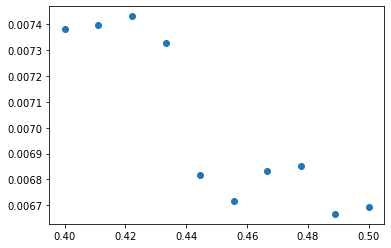

In [36]:
plt.scatter(np.linspace(0.4, 0.5, 10), auc)

In [34]:
obj_acc, attr_acc, report_cw, report_ow = evaluator.eval_model(compoResnet, 0.42)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:27<00:00,  7.48it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.202|OpUnseen:0.062|OpHM:0.064|OpAUC:0.00743|


Original:                  A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.060|OpHM:0.062|OpAUC:0.00706|
My Baseline:               A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.202|OpUnseen:0.063|OpHM:0.065|OpAUC:0.00793|
Compos feasibility score:  A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.080|OpHM:0.073|OpAUC:0.00992|

**Bert**

In [5]:
evaluator = CompoResnetEvaluatorFscore(test_dataloader, 20, 1e-5, './GoogleNews-vectors-negative300.bin')

In [ ]:
results = []
for t in tqdm.tqdm(np.linspace(0, 0.001, 20), total=20):
  results.append(evaluator.eval_model(compoResnet, t))
auc = [result[-1][-1] for result in results]

53753 activations loaded
#images = 34562


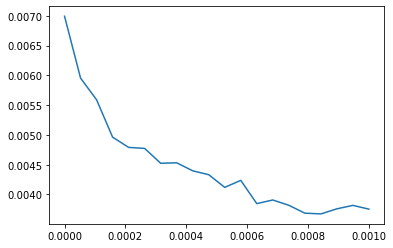

In [23]:
plt.plot(np.linspace(0, 0.001, 20), auc)

In [21]:
obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet, 0.00001)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:27<00:00,  7.40it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.059|OpHM:0.062|OpAUC:0.00681|


**Without applying Fscore**

In [11]:
obj_acc, attr_acc, report_cw, report_ow  = evaluator.eval_model(compoResnet)

print('A:{:.3f}|O:{:.3f}|CwSeen:{:.3f}|CwUnseen:{:.3f}|CwHM:{:.3f}|CwAUC:{:.5f}|OpSeen:{:.3f}|OpUnseen:{:.3f}|OpHM:{:.3f}|OpAUC:{:.5f}|'.format(
  attr_acc, obj_acc, *report_cw, *report_ow))

100%|██████████| 204/204 [00:26<00:00,  7.57it/s]


A:0.180|O:0.280|CwSeen:0.203|CwUnseen:0.205|CwHM:0.121|CwAUC:0.02645|OpSeen:0.203|OpUnseen:0.060|OpHM:0.062|OpAUC:0.00706|


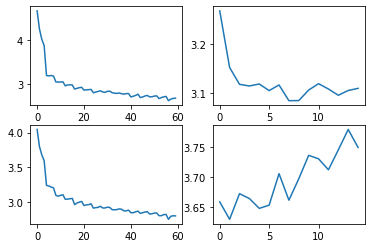

In [16]:
plt.subplot(2, 2, 1)
plt.plot(obj_loss_history[0])
plt.subplot(2, 2, 2)
plt.plot(obj_loss_history[1])
plt.subplot(2, 2, 3)
plt.plot(attr_loss_history[0])
plt.subplot(2, 2, 4)
plt.plot(attr_loss_history[1])

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "resnet": tune.choice(['resnet18', 'resnet50', 'resnet101']),
    "num_mlp_layers": tune.choice([1,2,4,6]),
}

In [ ]:
num_samples = 12
num_epochs = 6
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=num_epochs,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_with_config, num_epochs=num_epochs),
    resources_per_trial={"cpu": 1, "gpu": 0.32},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

resnet = frozen(torch.hub.load('pytorch/vision:v0.9.0', best_trial.config["resnet"], pretrained=True))
best_mlp = partial(HalvingMLP, num_layers=best_trial.config["num_mlp_layers"])
best_trained_model = CompoResnet(resnet, obj_class, attr_class, best_mlp).to(dev)

best_checkpoint_dir = best_trial.checkpoint.value
model_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))['model_state_dict']
best_trained_model.load_state_dict(model_state)

test_acc = calc_acc(best_trained_model, test_dataloader)
print("\nBest trial test set accuracy: {}".format(test_acc))

Matches:

[0.30456985, 0.15528112, 0.02720025] : MLP2, 30 Epochs, Adam

### UT Zappos